In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys

sys.path.append('/content/gdrive/My Drive/Colab Notebooks/ECE_Project')

In [0]:
import CNN_Lib
import CNN_BuildingBlock_Lib as BB
import RNN_BuildingBlock_Lib as RNN_BB
import CombinationModel as ComboCNN
import CombinationModel_RNN_CNN as RNN_CNN
import CombinationModel_LSTM_FCN as LSTM_FCN
import CombinationModel_LSTM as ComboLSTM
import numpy as np 
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import random
import pdb
import copy
import matplotlib.pyplot as plt


In [4]:
dir = '/content/gdrive/My Drive/Colab Notebooks/ECE_Project'
X_test = np.load(dir + '/X_test.npy')
y_test = np.load(dir + '/y_test.npy')
person_train_valid = np.load(dir + '/person_train_valid.npy')
X_train_valid = np.load(dir + '/X_train_valid.npy')
y_train_valid = np.load(dir + '/y_train_valid.npy')
person_test = np.load(dir + '/person_test.npy')
print ('Training/Valid data shape: {}' .format(X_train_valid.shape))
print ('Test data shape: {}' .format(X_test.shape))
print ('Training/Valid target shape: {}' .format(y_train_valid.shape))
print ('Test target shape: {}' .format(y_test.shape))
print ('Person train/valid shape: {}' .format(person_train_valid.shape))
print ('Person test shape: {}' .format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [0]:
#transform data into torch-readable data types
#2115 number of trials from 9 people
#four possible classes of outputs
Xtrain = torch.from_numpy(X_train_valid)
Ytrain = torch.from_numpy(y_train_valid)
Xtest = torch.from_numpy(X_test)
Ytest = torch.from_numpy(y_test)

In [0]:
def map_to_class(input_labels):
  mask1 = (input_labels == 769)*0
  mask2 = (input_labels == 770)*1
  mask3 = (input_labels == 771)*2
  mask4 = (input_labels == 772)*3

  return (mask1 + mask2 + mask3 + mask4)

In [0]:
#perhaps normalizing noisy data will help learning?
#tried first with L2, improved slightly...
def normalize(x):
  return F.normalize(x, p=1, dim=2)


In [0]:
def plot_val_train(validation_acc, train_acc, k, its):
  f = plt.figure(figsize=(15, 10))
  plt.title(f"Model Performance while Validating on K-Fold {k}")
  plt.plot(validation_acc, 'g-')
  plt.plot(train_acc, 'b-')
  plt.xticks(np.arange(0, its, step=50))  # Set label locations.
  return f


In [21]:
########## INITIALIZE LSTM-FCN COMBINATION MODEL ########## 

Trials, InputDim, SeqDim = X_train_valid.shape
num_features = InputDim
Tests = y_test.shape
num_classes = 4

#-----RNN tweak here----#
hidden_dim1 = 128 #above 150 and we get low training accuracy
hidden_dim2 = 64 #above 150 and we get low training accuracy
num_layers1 = 8 #5 seems to do better with 64
num_layers2 = 5 #5 seems to do better with 64
nonlinearity = 'tanh'
initialization = 'xavierUniform'

batch_size = 30
eps = 1e-3
momentum = 0.99
affine = False
dropoutLSTM = 0.06
dropoutFC = 0.02

#----NORM DATA tweak here---#
norm = True

#-----OPTIM tweak here----#
learning_rate = 0.0001 #when set to 0.2, the validation was very noisy | 0.001 and less noisy, but data SUPER overfits
L2 = 0 #model doesn't seem to be expressive enough if L2 is larger than .1

combo_model = ComboLSTM.CombinationModel_LSTM(InputDim, SeqDim, num_classes, batch_size,
                                                 hidden_dim1, hidden_dim2, num_layers1, num_layers2, 
                                                 dropoutLSTM, dropoutFC, 
                                                 eps, momentum, affine)
combo_model.to('cuda:0') #--- activate the GPU


CombinationModel_LSTM(
  (LSTM1): LSTM(22, 128, num_layers=8, bidirectional=True)
  (LSTM2): LSTM(256, 64, num_layers=5, bidirectional=True)
  (DropOutLSTM): Dropout(p=0.06, inplace=False)
  (FC1): Linear(in_features=128000, out_features=22, bias=True)
  (BN): BatchNorm1d(22, eps=0.001, momentum=0.99, affine=False, track_running_stats=True)
  (Activ): SELU()
  (DropOutFC): Dropout(p=0.02, inplace=False)
  (FC2): Linear(in_features=22, out_features=4, bias=True)
)

In [0]:
########## CHOOSE LOSS  ###########
loss = torch.nn.CrossEntropyLoss()

######### CHOOSE OPTIMIZER ########
optim = torch.optim.Adam(combo_model.parameters(), lr=learning_rate, weight_decay=L2)
#optim = torch.optim.Adadelta(combo_model.parameters()) << does worse than Adam, we overfit so much 

...... Training for Epoch 0 ......
______ Training for k-folds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] ______


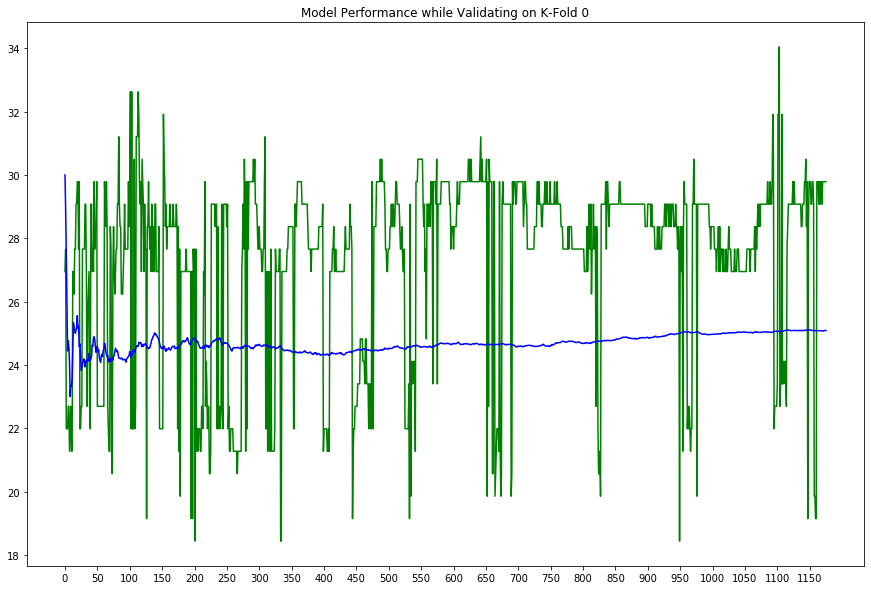

______ Training for k-folds [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14] ______


KeyboardInterrupt: ignored

In [23]:
######## TRAIN IT ######## .... got up to 58% but huge range. from 30 was the low.
#------ With Early Stopping AND K-Fold Validation -----#
epochs = 1
kfolds = 15
iterations = 1200
iter_ = 0
validate_fold = 0
SEED = 2000

stop_now = False
loss_store = [[] for i in range(kfolds)]
validation_store = [[] for i in range(kfolds)]
training_store = [[] for i in range(kfolds)]
network_store = [[] for i in range(kfolds)]
model_store = []

#normalize here
if norm:
  Xtrain = normalize(Xtrain)

#k fold validation here
np.random.seed(random.randint(1,SEED))
fold_size = int(Trials/kfolds)
idx = np.arange(Trials)
np.random.shuffle(idx)
Xtrain_Shuffled = Xtrain[idx]
Ytrain_Shuffled = Ytrain[idx]

FoldsX = Xtrain_Shuffled.split(fold_size)
FoldsY = Ytrain_Shuffled.split(fold_size)

for epoch in range(epochs):
  if stop_now:
    break

  print(f"...... Training for Epoch {epoch} ......")
  for k in range(kfolds): 
    train_correct = 0
    train_total = 0

    #create training folds by excluding validate fold
    train_folds = list(range(kfolds))
    del train_folds[validate_fold]
    train_folds = np.array(train_folds)
    TrainX = torch.cat([FoldsX[f] for f in train_folds]) 
    TrainY = torch.cat([FoldsY[f] for f in train_folds])

    #create validate fold
    ValidateX = FoldsX[validate_fold]
    ValidateY = FoldsY[validate_fold]

    #initialize the network within the kfold loop
    combo_model = ComboLSTM.CombinationModel_LSTM(InputDim, SeqDim, num_classes, batch_size,
                                                 hidden_dim1, hidden_dim2, num_layers1, num_layers2, 
                                                 dropoutLSTM, dropoutFC, 
                                                 eps, momentum, affine)

    combo_model.to('cuda:0') #--- activate the GPU
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(combo_model.parameters(), lr=learning_rate, weight_decay=L2) 
    

    print(f"______ Training for k-folds {train_folds} ______")
    for i in range(iterations):
      #do the batches
      idx = np.arange(TrainX.size(0))
      np.random.shuffle(idx)
      idx = idx[0:batch_size]

      #process the input data
      xtrain = TrainX[idx].view(batch_size, SeqDim, InputDim)
      xtrain = xtrain.to('cuda:0').requires_grad_()
      ytrain = TrainY[idx]

      #put the model in training mode
      combo_model.train(True)

      #forward pass
      optim.zero_grad()
      outFC = combo_model.forward(xtrain.float())
  
      #map to classes
      classes = map_to_class(ytrain.long())
      classes = classes.to('cuda:0')

      #backward pass (gradient calculation)
      probs = loss(outFC, classes)
      probs.backward()

      #update weights
      optim.step()

      #update iter counter
      iter_+=1

      #calculate training accuracy
      #train_pred = F.softmax(outFC, 1)
      values, predicted = torch.max(outFC, 1)
      train_correct += (1*(predicted == classes)).sum()
      train_total += float(classes.size(0))

      if i % 50:
        #print(f"______ Validating for k-fold {k} ______")
        combo_model.eval()
        
        total = 0
        correct = 0

        #process the input data
        idx = np.random.randint(0, Tests, size=batch_size)
        xvalid = ValidateX.view(-1, SeqDim, InputDim)
        xvalid = xvalid.to('cuda:0')
        yvalid = ValidateY

        #forward prop
        predict = combo_model(xvalid.float())
        
        #predict
        values, predicted_classes = torch.max(predict, 1)
        expected_classes = map_to_class(yvalid)
        #expected_classes = torch.cat((expected_classes,expected_classes))        
        correct += (1*(predicted_classes == expected_classes.to('cuda:0'))).sum()
        total +=float(predicted_classes.size(0))

        #evaluate
        validation_accuracy = 100*(correct/total)
        training_accuracy = 100*(train_correct/train_total)

        #print(f"correct: {correct}, total: {total}")
        #print(f"prediction: {predicted_classes}\nexpected_classes: {expected_classes}")
        #print(f"Iteration: {iter_}, Loss: {probs.item()}, Validation Accuracy: {validation_accuracy}%, Training Accuracy: {training_accuracy}%\n")  

        #store info for graphing later
        validation_store[k].append(validation_accuracy.item())
        loss_store[k].append(probs.item())
        training_store[k].append(training_accuracy.item())
        
        #--- Early stopping criterion here --- #
        if validation_accuracy > 73.0:
          #store
          print("Early Stopping!")
          stop_now = True
          break
    
    #iterate the validate fold
    validate_fold +=1

    #store the model
    model_store.append(copy.deepcopy(combo_model))

    #plot things
    plot = plot_val_train(validation_store[k], training_store[k], k, iterations)    
    plt.show(plot)